[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
D:\Anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Best Parameters: {'batch_size': 32, 'epochs': 20, 'model__dropout_rate': 0.3, 'model__layers': 2, 'model__units': 100, 'optimizer': 'adam'}
Best Score: 25.90005012899105


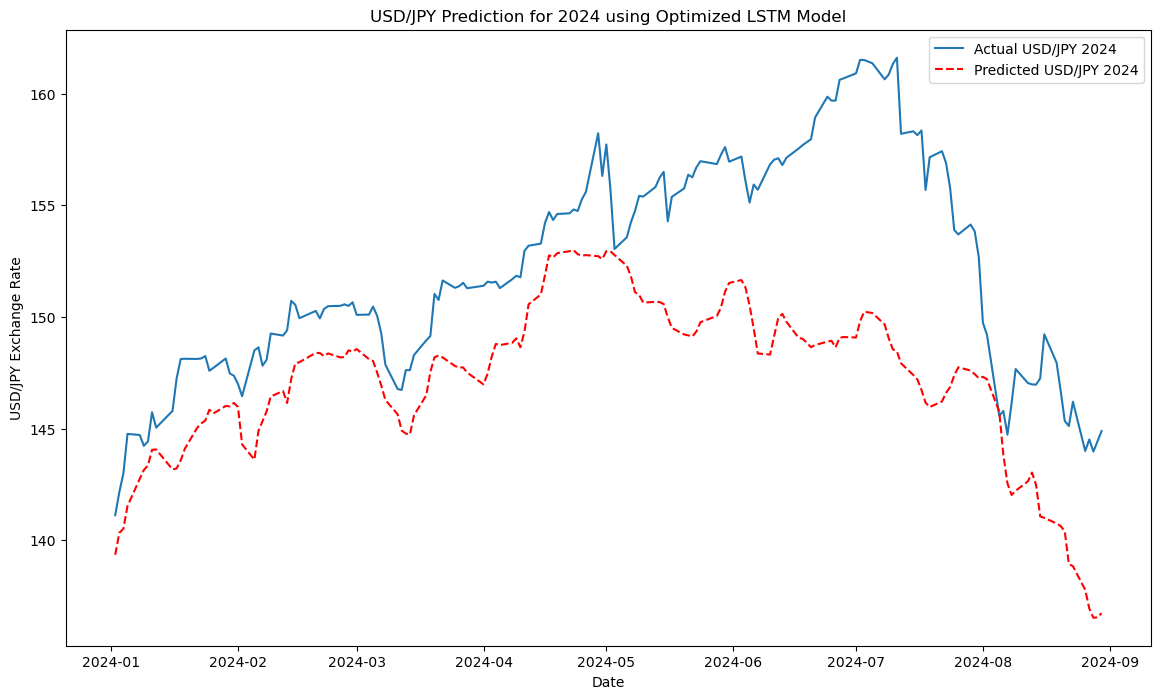

In [3]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from scikeras.wrappers import KerasRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
import datetime as dt

# Step 1: Data Collection

end_date = dt.datetime.now().strftime('%Y-%m-%d')  # Today's date as end date
eur_usd = yf.download('EURUSD=X', start='2010-01-01', end=end_date)['Close']
gbp_usd = yf.download('GBPUSD=X', start='2010-01-01', end=end_date)['Close']
treasury_10y = yf.download('^TNX', start='2010-01-01', end=end_date)['Close']
treasury_30y = yf.download('^TYX', start='2010-01-01', end=end_date)['Close']

yield_spread = treasury_10y - treasury_30y

data = pd.DataFrame({
    'EUR/USD': eur_usd,
    'GBP/USD': gbp_usd,
    '10Y Treasury': treasury_10y,
    '30Y Treasury': treasury_30y,
    '10Y-30Y Spread': yield_spread
})

data.dropna(inplace=True)

# Step 2: Feature Engineering with Adjusted Lags

lags = 5  # Adjusting the number of lags to 5 days

for col in data.columns:
    for lag in range(1, lags + 1):
        data[f'{col}_lag{lag}'] = data[col].shift(lag)

data.dropna(inplace=True)

X = data
y = yf.download('JPY=X', start='2010-01-01', end=end_date)['Close']
y = y.iloc[lags:]

X = X.iloc[lags:]

y = y[X.index]
assert X.shape[0] == y.shape[0]
# Train/Test Split
train_end_date = '2023-12-31'
X_train, X_test = X[:train_end_date], X[train_end_date:]
y_train, y_test = y[:train_end_date], y[train_end_date:]

scaler_X = MinMaxScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

scaler_y = MinMaxScaler()
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

X_train_scaled = X_train_scaled.reshape(X_train_scaled.shape[0], X_train_scaled.shape[1], 1)
X_test_scaled = X_test_scaled.reshape(X_test_scaled.shape[0], X_test_scaled.shape[1], 1)

# Step 3: Model Definition with Adjusted Hyperparameters

def create_model(units=50, layers=1, dropout_rate=0.2, optimizer='adam'):
    model = Sequential()
    model.add(LSTM(units=units, return_sequences=(layers > 1), input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2])))
    model.add(Dropout(dropout_rate))

    for _ in range(1, layers):
        model.add(LSTM(units=units, return_sequences=(_ < layers - 1)))
        model.add(Dropout(dropout_rate))

    model.add(Dense(units=25))
    model.add(Dense(1))
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# Step 4: Hyperparameter Tuning with Cross-Validation

model = KerasRegressor(model=create_model, verbose=0)

param_grid = {
    'model__units': [50, 100],
    'model__layers': [1, 2],
    'model__dropout_rate': [0.2, 0.3],
    'optimizer': ['adam', 'rmsprop'],
    'batch_size': [32, 64],
    'epochs': [10, 20]
}

tscv = TimeSeriesSplit(n_splits=3)

grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=tscv, n_jobs=-1)
grid_result = grid.fit(X_train_scaled, y_train_scaled)

print(f"Best Parameters: {grid_result.best_params_}")
print(f"Best Score: {-grid_result.best_score_}")

# Step 5: Evaluate the Model on 2024 Data

best_model = grid_result.best_estimator_

usd_jpy_predictions_2024_scaled = best_model.predict(X_test_scaled)
usd_jpy_predictions_2024 = scaler_y.inverse_transform(usd_jpy_predictions_2024_scaled.reshape(-1, 1)).flatten()

plt.figure(figsize=(14, 8))
plt.plot(y_test.index, y_test, label='Actual USD/JPY 2024')
plt.plot(y_test.index, usd_jpy_predictions_2024, color='r', linestyle='--', label='Predicted USD/JPY 2024')
plt.title('USD/JPY Prediction for 2024 using Optimized LSTM Model')
plt.xlabel('Date')
plt.ylabel('USD/JPY Exchange Rate')
plt.legend()
plt.show()
